In [17]:
from sklearn import cluster, datasets, mixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn import cluster, datasets, mixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split

First we load the data

In [19]:
noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)

A_feature = list()
B_feature = list()

for i in range(len(noisy_moons[0])):
    A_feature.append(noisy_moons[0][i][0])
    B_feature.append(noisy_moons[0][i][1])

Data = pd.DataFrame({
    'A': A_feature,
    'B': B_feature,
    'Label': noisy_moons[1]
})

X = np.asarray(Data)
y = np.asarray(Data["Label"])
y= y.reshape(len(y), )
training_data, testing_data, training_labels, testing_labels = train_test_split(X,y) 

class_0 = []
class_1 = []
for row in training_data:
    if (row[2] == 0):
        class_0.append(row)
    else:
        class_1.append(row)

class_0 = np.delete(class_0, 2, axis=1)
class_1 = np.delete(class_1, 2, axis=1)

zero_data = Data.loc[Data["Label"] == 0]
one_data = Data.loc[Data["Label"] == 1]

In [3]:
(Data)

A         B  Label
0    2.133911  0.437998      1
1   -0.809799  0.560906      0
2   -0.873442  0.255947      0
3    0.816797  0.466377      0
4    0.833920  0.563785      0
..        ...       ...    ...
495  0.153004  0.398819      1
496 -0.997209  0.493283      0
497  1.715200 -0.300240      1
498  0.708195  0.706455      0
499 -0.993986  0.127916      0

[500 rows x 3 columns]

#A

first we calculate the mean and covariance matrix of each class,then we estimate the distribution of the data and plot

In [21]:
def mean_cov_calculator(class_i):

    mean_vect = np.average(class_i, axis=0)
    feature_0_mean = mean_vect[0]
    feature_1_mean = mean_vect[1]

    sum_feature_0 = sum_feature_1 = 0
    for i in range (len(class_i)):
        sum_feature_0 += float(class_i[i][0])
        sum_feature_1 += float(class_i[i][1])

    sigma_0 = sigma_1 = 0
    for i in range (len(class_i)):
        sigma_0 += (float(class_i[i][0]) - feature_0_mean) ** 2
        sigma_1 += (float (class_i[i][1]) - feature_1_mean) ** 2

    var_0 = sigma_0 / (len(class_i))
    var_1 = sigma_1 / (len(class_i))

    cov = 0

    for i in range (len(class_i)):
            cov +=  (float (class_i[i][0]) - feature_0_mean)*(float (class_i[i][1])  - feature_1_mean)
           
    cov /= (len(class_i))
    
    cov_matrix = [[var_0, cov],
                 [cov, var_1]]

    return mean_vect, cov_matrix

In [23]:
mean_0, cov_0 = mean_cov_calculator(class_0)
print("mean of class 0:", mean_0)
print("covaraince of class 0:", cov_0)
mean_1, cov_1 = mean_cov_calculator(class_1)
print("mean of class 1:", mean_1)
print("covariance of class 1:", cov_1)

mean of class 0: [0.01290868 0.64604592]
covaraince of class 0: [[0.5010271928353532, -0.0004569321963039114], [-0.0004569321963039114, 0.10460399738173062]]
mean of class 1: [ 1.0166566  -0.14803288]
covariance of class 1: [[0.4834039398298245, 0.02162875784636734], [0.02162875784636734, 0.10027956438019424]]


In [24]:
def daistribution_calc (test_sample, train_set, class_i):
    test_sample = (test_sample[0:2])
    mean_class_i, cov_class_i = mean_cov_calculator(class_i)
    W = np.dot(-0.5, np.linalg.inv(cov_class_i))
    w = np.dot(np.linalg.inv(cov_class_i),mean_class_i)
    A = np.dot(- 0.5 ,np.transpose(mean_class_i))
    B = np.dot(A, np.linalg.inv(cov_class_i))
    w0 = (np.dot(B, mean_class_i)) - 0.5 * np.log(np.linalg.det(cov_class_i)) + np.log(len(class_i) / len(train_set))
    C = np.dot(np.transpose(test_sample), W)
    return (np.dot(C, test_sample) + np.dot(np.transpose(w), test_sample)+ w0)

In [25]:
def class_estimator (test, train, class_0, class_1):
    G0 = daistribution_calc (test, train, class_0)
    G1 = daistribution_calc (test, train, class_1)
    if (G0 >= G1):
        return ('0')
    else:
        return ('1')

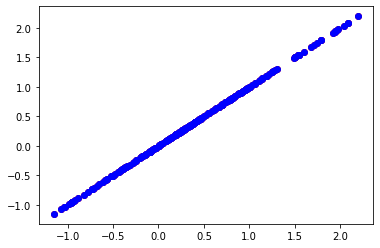

In [26]:
x1 = x2 = y1 = y2 = []
for i in range (len(testing_data)):
    estmation = class_estimator (testing_data[i], training_data, class_0, class_1)
    if (estmation == 0):
        x1.append(testing_data[i][0])
        y1.append(testing_data[i][1])
    else:
        x2.append(testing_data[i][0])
        y2.append(testing_data[i][1])

plt.scatter(x1, y1, c='red', label='Zero')
plt.scatter(x2, y2, c='blue', label='One')
plt.show() 

as we can see the estimation is not good

#B

In [7]:
from scipy.special import logsumexp

class multivariate_normal_new:
    def __init__(self, mean, covariance):
        self.Data = None
        self.mean = mean
        self.covariance = covariance
                
    def pdf(self, Data):
        self.Data = Data
        dim = len(self.Data)
        det = np.linalg.det(self.covariance)
        inv = np.linalg.inv(self.covariance)

        temp1 = (2 * np.pi) ** dim
        temp2 = 1 / (np.sqrt(temp1 * det))
        temp3 = np.dot((self.Data - self.mean).T, inv)
        temp4 = np.dot(temp3, (self.Data - self.mean)) * -0.5
        temp5 = logsumexp(temp4)
        
        result = temp2 * temp5
        return result

We build a class GMM. in each iteration, We do the E step where we estimate Ez|x,a(log(P(H,D|A)))=Q
where D is the set of seen samples (x), H is set of unseen samples zi(zij is 1 if xi belongs to class j)
and A IS set of a(vector of mean,covariance matrix and weight of each distribution.) 
Then we do the M step. where we update a inorder to maximize Q

In [8]:
class GMM:
    def __init__(self, n_components, max_iter=100):
        self.n_componets = n_components
        self.max_iter = max_iter
        self.prob = [1/self.n_componets for _ in range(self.n_componets)]
        self.r = None
        self.mean = None
        self.covariance = None

    def fit(self, Data):
        temp_clustering = np.array_split(Data, self.n_componets)
        self.mean = [np.mean(data_clus, axis=0) for data_clus in temp_clustering]
        self.covariance = [np.cov(np.transpose(data_clus)) for data_clus in temp_clustering]

        for iteration in range(self.max_iter):
            self.E_step(Data)
            self.M_step(Data)

    def E_step(self, Data):
        self.w = np.array([[float(0) for i in range(self.n_componets)] for _ in range(len(Data))])
        for n in range(len(Data)):
            for k in range(self.n_componets):
                self.w[n][k] = (self.prob[k] * multivariate_normal_new(self.mean[k], self.covariance[k]).pdf(Data[n])) / \
                sum([self.prob[j] * multivariate_normal_new(self.mean[j], self.covariance[j]).pdf(Data[n]) for j in range(self.n_componets)])

    def M_step(self, Data):
        N = np.sum(self.w, axis=0)
        self.mean = np.array([[float(0) for i in range(len(Data[0]))] for _ in range(self.n_componets)])
        self.covariance = [np.array([[float(0) for i in range(len(Data[0]))] for _ in range(len(Data[0]))]) for _ in range(self.n_componets)]
        
        for k in range(self.n_componets):
            for n in range(len(Data)):
                self.mean[k] = self.mean[k] + self.w[n][k] * Data[n]
        self.mean = [1/N[x]*self.mean[x] for x in range(self.n_componets)]
        
        for k in range(self.n_componets):
            self.covariance[k] = np.cov(np.transpose(Data), aweights=(self.w[:, k]))
        self.covariance = [(1/N[x]*self.covariance[x]) for x in range(self.n_componets)]
        
        self.prob = [N[k]/len(Data) for k in range(self.n_componets)]
        
    def Mean(self):
        return self.mean
    
    def Covariance(self):
        return self.covariance

We define a function to print the means and covariance matrices

In [9]:
def GMM_EM(k):
    GMM_Z = GMM(n_components=k)
    GMM_O = GMM(n_components=k)

    GMM_Z.fit(Data_features_Zero) 
    GMM_O.fit(Data_features_One) 

    means_Z = GMM_Z.Mean() 
    covariances_Z = GMM_Z.Covariance()

    means_O = GMM_O.Mean() 
    covariances_O = GMM_O.Covariance()

    print("Means Matrix For Zero = ", means_Z, sep="\n")
    print()
    print("Means Matrix For One = ", means_O, sep="\n")
    print()
    print("Covariances Matrix For Zero = ", covariances_Z, sep="\n")
    print()
    print("Covariances Matrix For One = ", covariances_O, sep="\n")
    print()
    
    return means_Z, covariances_Z, means_O, covariances_O

We define a function to plot the contours

In [10]:
from scipy.stats import multivariate_normal

def plot_contour(means_Z, covariances_Z, means_O, covariances_O):
    fig = plt.figure(figsize=(10, 10))

    temp = fig.add_subplot(1, 1, 1)
    temp.scatter(Data_features_Zero[:, 0], Data_features_Zero[:, 1], c='red')
    temp.scatter(Data_features_One[:, 0], Data_features_One[:, 1], c='blue')

    for m, c in zip(means_Z, covariances_Z):
        m_n = multivariate_normal(mean=m, cov=c)
        temp.contour(f_1_zero, f_2_zero, m_n.pdf(XY_zero).reshape(len(Data_features_Zero), len(Data_features_Zero)), colors='green', alpha=0.3)
        temp.scatter(m[0], m[1], c='violet', zorder=10, s=100)

    for m, c in zip(means_O, covariances_O):
        m_n = multivariate_normal(mean=m, cov=c)
        temp.contour(f_1_one, f_2_one, m_n.pdf(XY_one).reshape(len(Data_features_One), len(Data_features_One)), colors='black', alpha=0.3)
        temp.scatter(m[0], m[1], c='yellow', zorder=10, s=100)

    plt.title("GMM", color = 'green', fontweight = 'bold') 
    plt.xlabel("R", color = 'green', fontweight = 'bold') 
    plt.ylabel("B", color = 'green', fontweight = 'bold') 

    plt.show()

We print the covarince matrices, the means, and the contour plot of 2 guassian distributions using gmm:

In [11]:
means_Z, covariances_Z, means_O, covariances_O = GMM_EM(k=1)

Means Matrix For Zero = 
[array([0.0021815 , 0.62635183])]

Means Matrix For One = 
[array([ 0.99777711, -0.13600446])]

Covariances Matrix For Zero = 
[array([[2.04652439e-03, 2.90686583e-05],
       [2.90686583e-05, 4.54281328e-04]])]

Covariances Matrix For One = 
[array([[2.11618032e-03, 1.44740231e-05],
       [1.44740231e-05, 4.37349798e-04]])]



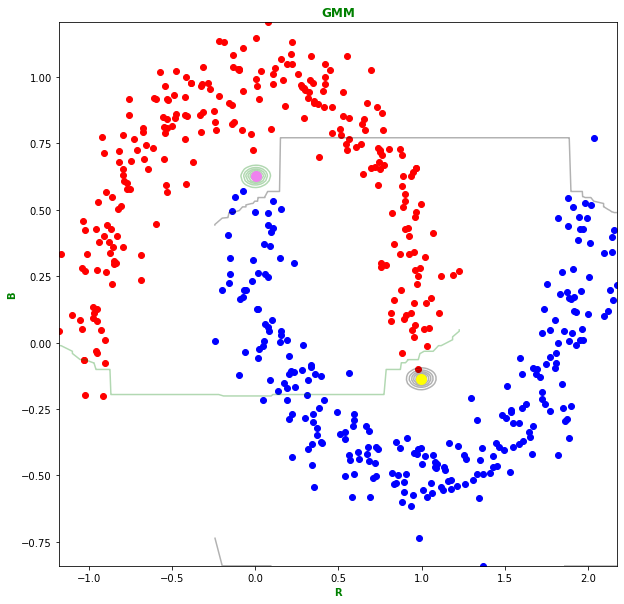

In [12]:
plot_contour(means_Z, covariances_Z, means_O, covariances_O)

for each i in [1,16], we estimate our data with mixture of i guassian distributions and plot for i=3,8, and 16

In [ ]:
for i in range(16):
    means_Z, covariances_Z, means_O, covariances_O = GMM_EM(i+1)

means_Z3, covariances_Z3, means_O3, covariances_O3 = GMM_EM(k=3)
plot_contour(means_Z3, covariances_Z3, means_O3, covariances_O3)

means_Z8, covariances_Z8, means_O8, covariances_O8 = GMM_EM(k=8)
plot_contour(means_Z8, covariances_Z8, means_O8, covariances_O8)



Then we calculate the BIC and AIC for each estimation. The best estimation has the least BIC/AIC factor

In [ ]:
aic = []
for k in range(1,101):
    gmm = GMM(k, max_iter=20)
    aic.append(gmm.fit(X).aic(X))
k = np.arange(1,101)
plt.plot(k, aic)
plt.title("aic by number of components")
plt.xlabel("components")
plt.ylabel("aic")
plt.show()

In [ ]:
bic = []
for k in range(1,101):
    gmm = GMM(k, max_iter=20)
    bic.append(gmm.fit(X).bic(X))
k = np.arange(1,101)
plt.plot(k, bic)
plt.title("aic by number of components")
plt.xlabel("components")
plt.ylabel("aic")
plt.show()